# ABOUT:
- in this notebook, i compare the training time, inference time and performance between SAR and LightGCN on the ML100k Dataset

In [1]:
from recommenders.models.sar import SAR
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.evaluation.python_evaluation import precision_at_k
from recommenders.models.deeprec.DataModel.ImplicitCF import ImplicitCF
from recommenders.models.deeprec.deeprec_utils import prepare_hparams
from recommenders.models.deeprec.models.graphrec.lightgcn import LightGCN
from recommenders.utils.timer import Timer

import pandas as pd

In [2]:
TOP_K = 10
MOVIELENS_DATA_SIZE = '100k'
EPOCHS = 40
BATCH_SIZE = 1024
SEED = DEFAULT_SEED  
COL_USER = "userID"
COL_ITEM = "itemID"
COL_RATING = "rating"
COL_TIMESTAMP = "timestamp"

yaml_file = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\code1\config\lightgcn.yml"
# user_file = "../../tests/resources/deeprec/lightgcn/user_embeddings.csv"
# item_file = "../../tests/resources/deeprec/lightgcn/item_embeddings.csv"

### read data

In [3]:
path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\data\ml-latest-small\ml-latest-small\ratings.csv"
df = pd.read_csv(path)
df.columns = ["userID", "itemID", "rating", "timestamp"] # better to follow the default colnames in the package

#### Train test split

In [88]:
train, test = python_stratified_split(df, ratio=0.8,
                                      min_rating=1, filter_by='user', 
                                      col_user=COL_USER, col_item=COL_ITEM, 
                                      seed=SEED)

In [89]:
print("""
Train:
Total Ratings: {train_total}
Unique Users: {train_users}
Unique Items: {train_items}

Test:
Total Ratings: {test_total}
Unique Users: {test_users}
Unique Items: {test_items}
""".format(
    train_total=len(train),
    train_users=len(train['userID'].unique()),
    train_items=len(train['itemID'].unique()),
    test_total=len(test),
    test_users=len(test['userID'].unique()),
    test_items=len(test['itemID'].unique()),
))


Train:
Total Ratings: 80672
Unique Users: 610
Unique Items: 8929

Test:
Total Ratings: 20164
Unique Users: 610
Unique Items: 5237



## Train and Evaluate: SAR

In [90]:
# logging.basicConfig(level=logging.DEBUG, 
#                     format='%(asctime)s %(levelname)-8s %(message)s')

model_sar = SAR(
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_timestamp=COL_TIMESTAMP,
    similarity_type="cosine", 
    time_decay_coefficient=30, 
    timedecay_formula=False,
    normalize=True
)

In [91]:
with Timer() as train_time:
    model_sar.fit(train)

In [93]:
print("Took {} seconds for training.".format(train_time.interval))

Took 3.8839795000003505 seconds for training.


In [109]:
with Timer() as test_time:
    top_k = model_sar.recommend_k_items(test, top_k=TOP_K, remove_seen=True)

In [110]:
print("Took {} seconds for inference.".format(test_time.interval))

Took 1.5468562999994901 seconds for inference.


In [96]:
eval_precision = precision_at_k(test, top_k, col_user='userID', col_item='itemID', col_rating='rating', k=TOP_K)
eval_precision

0.2145901639344263

## Train and Evaluate: LightGCN

In [97]:
data = ImplicitCF(train = train, test=test, 
                  adj_dir=None, 
                  col_user=COL_USER, col_item=COL_ITEM, 
                  seed=SEED)

C:\Users\tanch\anaconda3\envs\fyp1\lib\site-packages\recommenders\models\deeprec\DataModel\ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


In [98]:
loss_type = "AmpBPR2"
loss_neg_weight = 2
log_wandb = False

In [101]:
hparams = prepare_hparams(yaml_file,
                          n_layers=2,
                          loss_type = loss_type, 
                          loss_neg_weight = loss_neg_weight, 
                          log_wandb = log_wandb,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          learning_rate=0.01,
                          eval_epoch=100,
                          top_k=TOP_K,
                          )
# initiate model
model = LightGCN(hparams, data, seed=SEED)

Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.


In [102]:
with Timer() as train_time:
    model.fit()

Epoch 1 (train)4.7s: train loss = 0.46561 = (mf)0.46536 + (embed)0.00025
Epoch 2 (train)4.4s: train loss = 0.27482 = (mf)0.27419 + (embed)0.00062
Epoch 3 (train)4.4s: train loss = 0.23179 = (mf)0.23097 + (embed)0.00082
Epoch 4 (train)4.3s: train loss = 0.19831 = (mf)0.19730 + (embed)0.00101
Epoch 5 (train)4.4s: train loss = 0.16874 = (mf)0.16752 + (embed)0.00121
Epoch 6 (train)4.3s: train loss = 0.14983 = (mf)0.14841 + (embed)0.00142
Epoch 7 (train)4.2s: train loss = 0.12808 = (mf)0.12643 + (embed)0.00165
Epoch 8 (train)4.3s: train loss = 0.11054 = (mf)0.10866 + (embed)0.00188
Epoch 9 (train)4.3s: train loss = 0.10064 = (mf)0.09853 + (embed)0.00211
Epoch 10 (train)4.5s: train loss = 0.08822 = (mf)0.08585 + (embed)0.00237
Epoch 11 (train)4.5s: train loss = 0.07724 = (mf)0.07464 + (embed)0.00260
Epoch 12 (train)4.2s: train loss = 0.06777 = (mf)0.06490 + (embed)0.00287
Epoch 13 (train)4.3s: train loss = 0.05999 = (mf)0.05688 + (embed)0.00311
Epoch 14 (train)4.2s: train loss = 0.05244 = (m

In [103]:
print("Took {} seconds for training.".format(train_time.interval))

Took 170.1838004000001 seconds for training.


In [107]:
with Timer() as test_time:
    top_k = model.recommend_k_items(test, top_k=TOP_K, remove_seen=True)

In [108]:
print("Took {} seconds for inference.".format(test_time.interval))

Took 0.15202570000019477 seconds for inference.


In [106]:
eval_precision = precision_at_k(test, top_k, col_user='userID', col_item='itemID', col_rating='rating', k=TOP_K)
eval_precision

0.24098360655737705

## Train and Evaluate: Popularity Recommender

In [121]:
class PopRecommender():
    def __init__(self, COL_ITEM = "itemID", COL_USER = "userID"):
        self.COL_ITEM = COL_ITEM
        self.COL_USER = COL_USER
    def fit(self, train):
        self.train = train
        self.memory = train[COL_ITEM].value_counts().keys().tolist()
    def recommend(self, user_id, num_rec = 20, filtered_item_ids = [], remove_seen = True):
        if remove_seen:
            remove_item_ids = self._get_user_liked_item_ids(user_id)
            remove_item_ids += filtered_item_ids
        
        # recommend num_rec items
        rec_items = []
        count = 0
        for item_id in self.memory:
            if item_id not in filtered_item_ids: 
                count+=1
                rec_items.append(item_id)
            if count >= num_rec:
                break
        return rec_items
    
    def recommend_k_items(self, test, top_k=10, remove_seen=True):
        output = pd.DataFrame()
        for userID in test[self.COL_USER]:
            rec_items = self.recommend(userID, num_rec = top_k, remove_seen = remove_seen)
            tmp = pd.DataFrame(rec_items, columns = [self.COL_ITEM])
            tmp[self.COL_USER] = userID
            output = pd.concat([output, tmp], axis = 0)
        output["prediction"] = 1
        return output
    def _get_user_liked_item_ids(self, user_id):
        return self.train[self.train[self.COL_USER] == user_id][self.COL_ITEM].tolist()

In [122]:
rec = PopRecommender()
rec.fit(train)

In [123]:
top_k = rec.recommend_k_items(test, top_k = TOP_K, remove_seen = True)

In [124]:
eval_precision = precision_at_k(test, top_k, col_user='userID', col_item='itemID', col_rating='rating', k=TOP_K)
eval_precision

0.06245901639344264

## Comparison
- LightGCN has better performance
- Though LightGCN has a much longer training time, its inference time is much shorter than SAR

In [112]:
import seaborn as sb

In [125]:
precison_tmp = {
    "LightGCN":0.2410,
    "SAR":0.2146,
    "Popularity":0.062459
}
training_tmp = {
    "LightGCN":170.18,
    "SAR":3.884
}
inference_tmp = {
    "LightGCN":0.15,
    "SAR":1.5469
}

[Text(0.5, 0, 'Precision@10')]

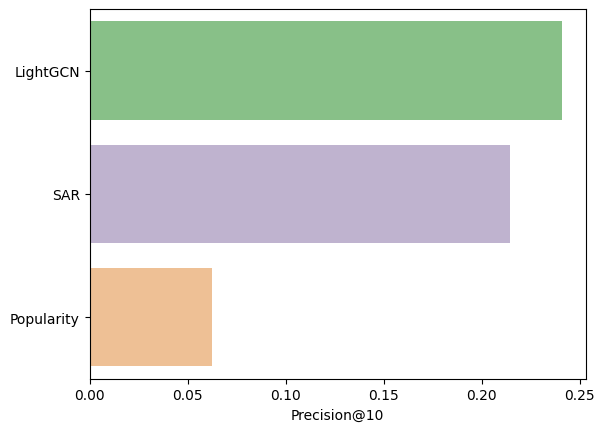

In [126]:
p = sb.barplot(x = list(precison_tmp.values()),y = list(precison_tmp.keys()), palette = "Accent")
p.set(xlabel = "Precision@10")

[Text(0.5, 0, 'Training time/seconds')]

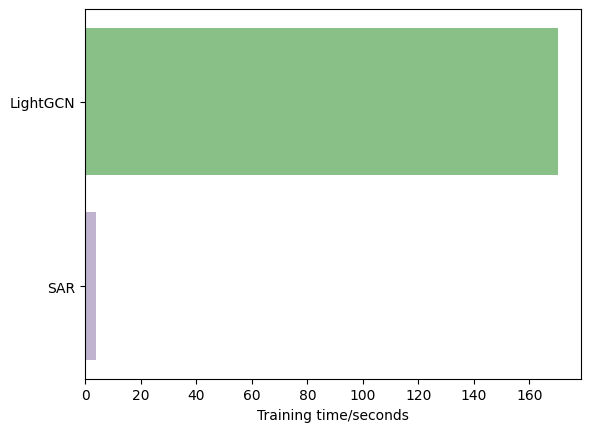

In [118]:
p = sb.barplot(x = list(training_tmp.values()),y = list(training_tmp.keys()), palette = "Accent")
p.set(xlabel = "Training time/seconds")

[Text(0.5, 0, 'Inference time/seconds')]

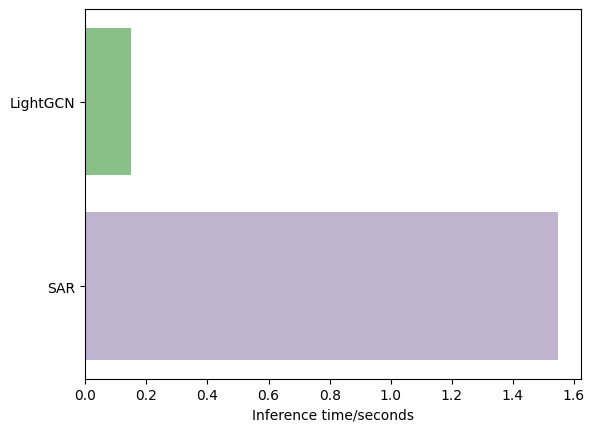

In [120]:
p = sb.barplot(x = list(inference_tmp.values()),y = list(inference_tmp.keys()), palette = "Accent")
p.set(xlabel = "Inference time/seconds")